In [1]:
include("../code/ldgm.jl")
include("../code/ldpc_graph.jl")
include("../code/bp_full.jl")
include("../code/bp.jl")
using Plots, StatsBase

## From H to B
**GOAL**: observe the performance of MaxSum when exploring the same space of codewords, represented in different ways: as the solutions of $Hx=0$ with $H$ parity-check matrix or as the span of $B$, with $B$ a basis.

1. Run MS on the graph defined by H and get a distortion $d_1$
2. Build the corresponding B using leaf removal
3. Run the LDGM version of MS on the graph defined by B and get distortion $d_2$
4. Draw a new random instance with the same degree profile as B. Run LDGM MS and get distortion $d_3$

In [3]:
n = 5000
m = 2500
H = ldpc_graphGF2(n,m).H
# remove 1 leaf
H = H[1:end-1,:];

#### 1. Run MaxSum on H. 
It takes a few attempts to get down to zero unsat

In [15]:
# Initalize messages and beliefs with some noise to avoid degeneracies
noise = 1e-8
s = rand((-1,1), n)   # source
efield = [(ss+noise*randn(),-ss+noise*randn()) for ss in s]
ms1 = BPFull(H, efield)
ms1.u .= [(noise*randn(),noise*randn()) for _ in 1:length(ms1.u)]
ms1.h .= [(noise*randn(),noise*randn()) for _ in 1:length(ms1.h)]
ms1.belief .=  [(noise*randn(),noise*randn() ) for _ in 1:length(ms1.belief)];

In [16]:
ε,iters = iteration!(ms1; maxiter=5*10^3, tol=1e-12, damp=0.6, rein=0.0, 
    update_f! = update_factor_ms!, update_v! = update_var_ms!)

(2.9658212024052943e-6, 5000)

In [17]:
nunsat, ovl, distH = performance(ms1,s)

(0, 0.716, 0.142)

#### 2. Build basis B with leaf-removal and show the obtained degree profile

In [18]:
B,indep = findbasis(H);

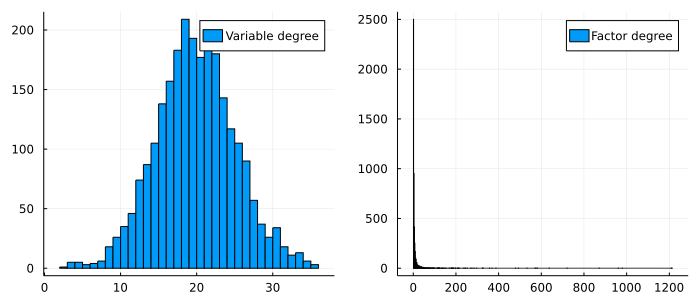

In [19]:
vardeg = vec(sum(B,dims=1))
factordeg = vec(sum(B,dims=2))
h1 = histogram(vardeg, label="Variable degree")
h2 = histogram(factordeg, label="Factor degree")
plot(h1,h2,size=(700,300))

#### 3.Run MS on the corresponding LDGM instance

In [20]:
k = size(B,2)

2501

In [55]:
ms2 = LDGM(B, s, efield)
ms2.prior .= [(noise*randn(),noise*randn()) for _ in 1:length(ms2.prior)];
# ms2.u .= [(noise*randn(),noise*randn()) for _ in 1:length(ms2.u)]
# ms2.h .= [(noise*randn(),noise*randn()) for _ in 1:length(ms2.h)]
# ms2.belief .=  [(noise*randn(),noise*randn()) for _ in 1:length(ms2.belief)];

In [56]:
maxiter = 10^4
dist2 = fill(NaN, maxiter)
ε,iters = iteration!(ms2; maxiter=maxiter, tol=1e-12, damp=0.5, rein=5e-4, dist=dist2,
    update_f! = update_factor_ms!, update_v! = update_var_ms!)

(5.987371192354203, 10000)

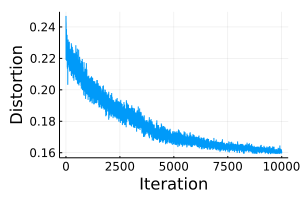

In [57]:
plot(dist2, label="", xlabel="Iteration", ylabel="Distortion", size=(300,200))

In [58]:
distB = minimum(dist2)

0.1594

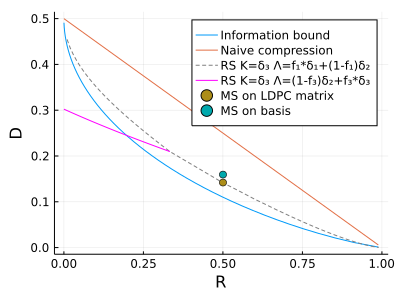

In [60]:
plot_rdb()
scatter!([k/n], [distH], label="MS on LDPC matrix")
scatter!([k/n], [distB], label="MS on basis")
plot!(size=(400,300))

#### 4. Draw a new instance from the ensemble

In [74]:
Lambda = proportions(vardeg, 1:maximum(vardeg))
Rho = proportions(factordeg, 1:maximum(factordeg))
n3, k3, nedges, P, Λ = valid_degrees(Rho, Lambda, 2*3*5*7)

(428820, 126210, 2454484, [0.5, 0.0, 0.19047619047619047, 0.0, 0.08095238095238096, 0.0, 0.05238095238095238, 0.0, 0.03333333333333333, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004761904761904762, 0.009523809523809525, 0.009523809523809525, 0.014285714285714285  …  0.0380952380952381, 0.023809523809523808, 0.014285714285714285, 0.009523809523809525, 0.014285714285714285, 0.009523809523809525, 0.004761904761904762, 0.004761904761904762, 0.0, 0.0])

In [75]:
k/n, k3/n3

(0.5002, 0.29431929480901076)

In [206]:
s = rand((-1,1), n)   # source
efield = [(ss+noise*randn(),-ss+noise*randn()) for ss in s]
ms3 = ldgm(n, k, nedges, Λ, P, efield=efield)
ms3.u .= [(noise*randn(),noise*randn()) for _ in 1:length(ms3.u)]
ms3.h .= [(noise*randn(),noise*randn()) for _ in 1:length(ms3.h)]
ms3.belief .=  [(noise*randn(),noise*randn()) for _ in 1:length(ms3.belief)];

In [207]:
maxiter = 10^3
dist3 = fill(NaN, maxiter)
ε,iters = iteration!(ms3; maxiter=maxiter, tol=1e-12, damp=0.7, rein=0.0, dist=dist3,
    update_f! = update_factor_ms!, update_v! = update_var_ms!)

LoadError: InterruptException:

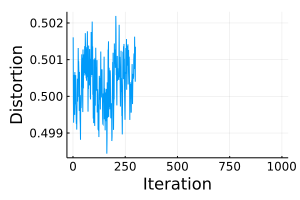

In [208]:
plot(dist3, label="", xlabel="Iteration", ylabel="Distortion", size=(300,200))

In [166]:
distB3 = minimum(dist3)

0.2006

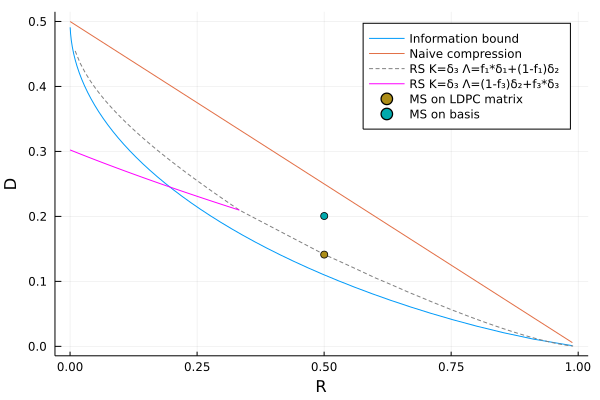

In [167]:
plot_rdb()
scatter!([k/n], [distH], label="LDPC matrix")
scatter!([k/n], [distB], label="Basis")
scatter!([k3/n3], [distB3], label="Same degrees as basis")

### From sparse B, build H
Start from $B\in\{0,1\}^{n,k}$ and build $H\in\{0,1\}^{n-k,n}$ such that $HB=0$

In [256]:
lambda = zeros(7); lambda[7] = 1
rho = [0.01, 0.266598, 0.25537, 0.076598, 0, 0, 0, 0, 0.39233]
Lambda, Rho = edges2nodes(lambda, rho)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.03434489872357184, 0.4578140654953402, 0.29235522623461796, 0.06576876381070389, 0.0, 0.0, 0.0, 0.0, 0.149717045735766])

In [257]:
n, k, nedges, P, Λ = valid_degrees(Rho, Lambda, B=1)
check_consistency_polynomials_ldgm(n, k, nedges, Λ, P)
B = ldgm_matrix(n, k, nedges, Λ, P);

In [258]:
# Bred, indep = gfrcefGF2(Array(B))
# dep = setdiff(1:n,indep)
# H = sparse([Bred[dep,:] I])

744×1470 SparseMatrixCSC{Bool, Int64} with 217880 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⢄

In [327]:
function findH(B)
    A = sparse(B')
    rowperm, colperm = leaf_removal(A)
    Anew = A[rowperm, colperm]
    ut2diagGF2!(Anew)
    Ht = [Anew[:, size(Anew, 1)+1:end]; I]
    indep = colperm[size(A,1)+1:end]
    H = sparse(Ht')
    H, indep
end

findH (generic function with 1 method)

In [282]:
H,indep = findH(B)

(
⣼⣿⣿⣿⣿⣿⣾⣯⣿⣾⣾⣾⣿⣿⣷⣶⣦⡄⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣆⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⢄, [338, 77, 1334, 744, 113, 1397, 1290, 1255, 594, 182  …  184, 202, 383, 770, 53, 87, 91, 410, 587, 828])

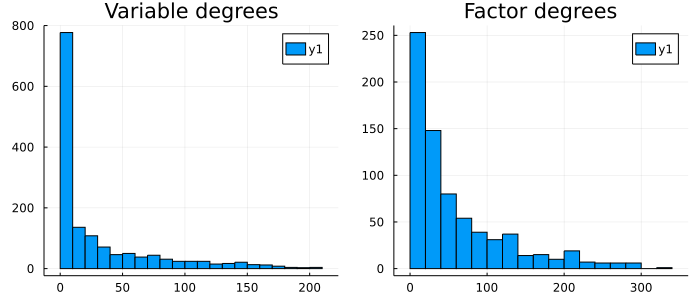

In [262]:
LambdaH = vec(sum(H,dims=1))
RhoH = vec(sum(H,dims=2))
h1 = histogram(LambdaH, title="Variable degrees")
h2 = histogram(RhoH, title="Factor degrees")
plot(h1,h2, size=(700,300))

#### Observe sparsity

In [263]:
sp_B = nnz(B)/length(B)
sp_H = nnz(H)/length(H)
sp_B, sp_H

(0.004753471636588519, 0.040676711455932234)

In [320]:
function B2H_size(Rho, Lambda, size_factors, navg)
    nn = Int[]; avg_B = Float64[]; sd_B = Float64[]; avg_H = Float64[]; sd_H = Float64[]
    sz_B = zeros(navg); sz_H = zeros(navg)
    @showprogress for b in size_factors
        n, k, nedges, P, Λ = valid_degrees(Rho, Lambda, B=b)
        push!(nn,n)
        check_consistency_polynomials_ldgm(n, k, nedges, Λ, P)
        for i in 1:navg
            B = ldgm_matrix(n, k, nedges, Λ, P)
#             B = B[:,1:end-1]
#             Bred, indep = gfrcefGF2(Array(B))
            H, indep = findH(B)
#             dep = setdiff(1:n,indep)
#             H = sparse([Bred[dep,:] I])
            sz_B[i] = nnz(B)/length(B); sz_H[i] = nnz(H)/length(H)
        end
        push!(avg_B, mean(sz_B)); push!(sd_B, std(sz_B)/sqrt(navg))
        push!(avg_H, mean(sz_H)); push!(sd_H, std(sz_H)/sqrt(navg))
    end
    avg_B, sd_B, avg_H, sd_H, nn
end

B2H_size (generic function with 1 method)

In [321]:
navg = 5
avg_B, sd_B, avg_H, sd_H, nn = B2H_size(Rho, Lambda, 1:8, navg)

Progress: 100%|█████████████████████████████████████████| Time: 0:06:35


([0.004749910983677217, 0.0023783287419651055, 0.00158615634806111, 0.0011895040385300124, 0.0009518937051404584, 0.0007932863993470055, 0.0006800426360458166, 0.0005950829023069283], [1.3707331982466234e-6, 5.310893746722245e-7, 2.57139297223463e-7, 7.076238951198117e-8, 6.704725855961515e-8, 3.947366597354478e-8, 6.047139182071072e-9, 2.2963264283261436e-8], [0.03911802355350742, 0.024219561480506184, 0.018859568917172602, 0.014557103083168751, 0.012392941262526515, 0.010867799031201488, 0.0097906300988686, 0.008641113031233999], [0.001492695022219827, 0.000838920074329385, 0.00048264820307326574, 0.00028523777368405707, 0.00014528807442801077, 0.0003493300687649247, 0.00014785981711097285, 0.0001309682198195578], [1470, 2940, 4410, 5880, 7350, 8820, 10290, 11760])

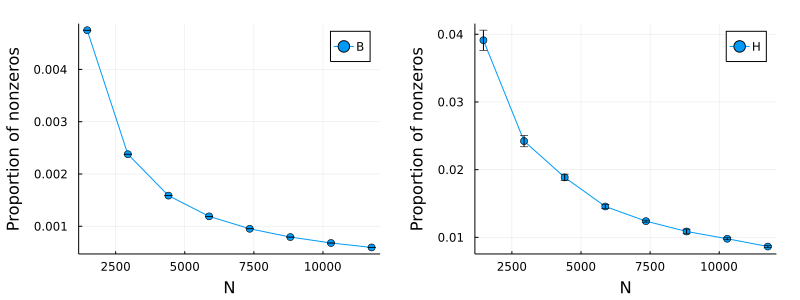

In [322]:
pb = plot(nn, avg_B, marker=:circle, yerr=sd_B, label="B", xlabel="N", ylabel="Proportion of nonzeros")
ph = plot(nn, avg_H, marker=:circle, yerr=sd_H, label="H", xlabel="N", ylabel="Proportion of nonzeros")
plot(pb,ph, size=(800,300), margin=4*Plots.mm)

### From sparse H, build B

In [323]:
methods(findH)

# 1 method for generic function "findH":
[1] findH(B) in Main at In[293]:1